In [1]:
# import libraries
import pandas as pd 
import numpy as np
from scipy import sparse 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pivottablejs import pivot_ui

from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading in dataframes
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')

#### ratings df

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
ratings.shape

(100836, 4)

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
# tally number of users
# 610 users
viewers = ratings['userId'].unique()
len(viewers)

610

In [7]:
# adverage rating 3.5 with a maximum movie rating of 5.0
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

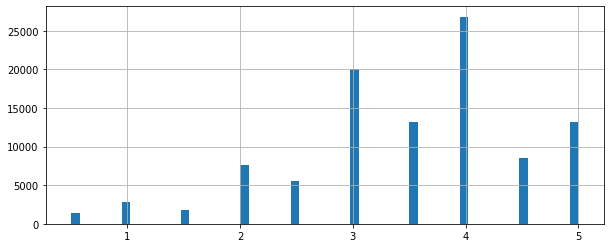

In [8]:
# majority of the ratings lay between 3 and 4
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=60)

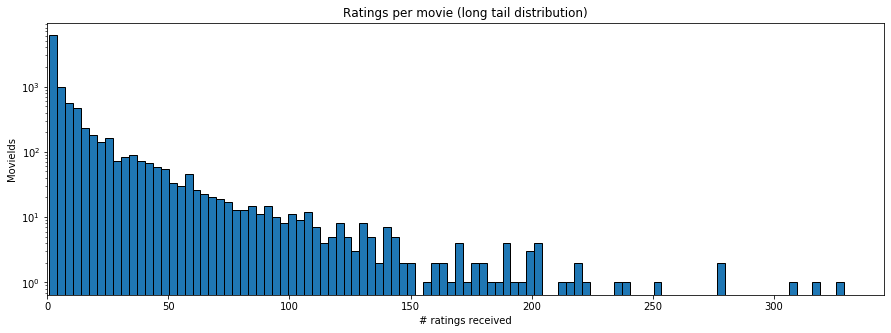

In [9]:
# Histogram of ratings counts.
rate_dist = ratings[['userId', 'movieId']].groupby('movieId').count()
rate_dist.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.hist(rate_dist.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per movie (long tail distribution)')
plt.xlabel('# ratings received')
plt.ylabel('MovieIds')
plt.xlim(0,)
plt.show()

#### movies df

In [10]:
# no meta data! 
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
movies.shape

(9742, 3)

In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [13]:
# tally number of movies 9737
# number of movies out number the users may lead to noise in the data set 
# since there are many possible non rated movies
films = movies['title'].unique()
len(films)

9737

#### merge

In [14]:
# dropping timestamp
ratings = pd.merge(movies, ratings).drop(['timestamp'], axis= 1)
ratings.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


#### pivot_table user-item matrix

In [15]:
# numerous NaN's many unrated or low-level rated films as expected
user_ratings = ratings.pivot_table(index=['userId'], columns=['title'], values='rating')
user_ratings.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### dropna() with  threshold

In [16]:
# remove any films with < 10 users rating, and remaing NaN changed to 0 values
# threshold can be easily adjusted to allow for more films, this is occuring on column data axis 1
user_ratings = user_ratings.dropna(thresh= 10, axis=1).fillna(0,axis=1)
user_ratings.head(5)

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Similarity matrix

##### Cosine similarity

In [17]:
# to compute a similarity score three options are available: euclidean, correlation (pearson), and cosine
tfV = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfV_matrix = tfV.fit_transform(movies['genres'])

cosine_similarity = linear_kernel(tfV_matrix, tfV_matrix)

In [18]:
type(tfV_matrix)

scipy.sparse.csr.csr_matrix

#####  Pearson similarity

In [19]:
# corr(pearson) method adjusts for the mean by default so no further need to standardize. 
pearson_similarity = user_ratings.corr(method='pearson')
pearson_similarity.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",1.000000,0.063117,-0.023768,0.143482,0.011998,0.087931,0.224052,0.034223,0.009277,0.008331,...,0.017477,0.032470,0.134701,0.153158,0.101301,0.049897,0.003233,0.187953,0.062174,0.353194
(500) Days of Summer (2009),0.063117,1.000000,0.142471,0.273989,0.193960,0.148903,0.142141,0.159756,0.135486,0.200135,...,0.374515,0.178655,0.068407,0.414585,0.355723,0.252226,0.216007,0.053614,0.241092,0.125905
10 Cloverfield Lane (2016),-0.023768,0.142471,1.000000,-0.005799,0.112396,0.006139,-0.016835,0.031704,-0.024275,0.272943,...,0.242663,0.099059,-0.023477,0.272347,0.241751,0.195054,0.319371,0.177846,0.096638,0.002733
10 Things I Hate About You (1999),0.143482,0.273989,-0.005799,1.000000,0.244670,0.223481,0.211473,0.011784,0.091964,0.043383,...,0.243118,0.104858,0.132460,0.091853,0.158637,0.281934,0.050031,0.121029,0.130813,0.110612
"10,000 BC (2008)",0.011998,0.193960,0.112396,0.244670,1.000000,0.234459,0.119132,0.059187,-0.025882,0.089328,...,0.260261,0.087592,0.094913,0.184521,0.242299,0.240231,0.094773,0.088045,0.203002,0.083518


In [20]:
type(pearson_similarity)

pandas.core.frame.DataFrame

In [21]:
def pearson(s1, s2):
    """returns correlation value between two titles"""
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(s1_c ** 2) * np.sum(s2_c ** 2))


pearson(pearson_similarity['10 Things I Hate About You (1999)'],
       pearson_similarity['Zombieland (2009)'])

0.24884743486026395

#### making predictions

##### Cold start genre-based recommendations

In [22]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# only title parameter
def genre_based_recommendations(title):
    idx = indices[title]
    similarity_scores = list(enumerate(cosine_similarity[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:11]
    #
    movie_indices = [i[0] for i in similarity_scores]

    return titles.iloc[movie_indices]

##### User ratings-based recommendations 

In [23]:
def get_similar_movies(movie_name, user_rating):
    # weighted user ratings 
    similar_score = pearson_similarity[movie_name] * (user_rating-2.5)
    # valid values at top of the returned values
    similar_score = similar_score.sort_values(ascending= False)
    
    return similar_score

In [24]:
# rating_based recommendations
user = [('Scott Pilgrim vs. the World (2010)', 1), ('2001: A Space Odyssey (1968)', 4), ('Zoolander (2001)', 3)]

# empty dataframe to hold values
similar_movies = pd.DataFrame()
    
for movie, rating in user:
    similar_movies = similar_movies.append(get_similar_movies(movie, rating), ignore_index = True)

In [25]:
similar_movies.sum().sort_values(ascending=False).head(10)

2001: A Space Odyssey (1968)             1.280072
Blade Runner (1982)                      0.671624
African Queen, The (1951)                0.627018
Lawrence of Arabia (1962)                0.622976
2010: The Year We Make Contact (1984)    0.616504
North by Northwest (1959)                0.596037
Abyss, The (1989)                        0.587159
Untouchables, The (1987)                 0.586499
Clockwork Orange, A (1971)               0.570817
Chinatown (1974)                         0.568316
dtype: float64

##### Genre based recommendations

In [26]:
# genre based recommendations
genre_based_recommendations('Zombieland (2009)')

7154                                    Zombieland (2009)
8434                                    Zombeavers (2014)
8565                    Dead Snow 2: Red vs. Dead (2014) 
9035         Scouts Guide to the Zombie Apocalypse (2015)
62                             From Dusk Till Dawn (1996)
6251                             Snakes on a Plane (2006)
6324                                         Feast (2005)
11                     Dracula: Dead and Loving It (1995)
654     Tales from the Crypt Presents: Bordello of Blo...
1478                                      Gremlins (1984)
Name: title, dtype: object

#### PySpark |  ALS

In [27]:
# import necessary libraries
from pyspark.sql import SparkSession
# instantiate SparkSession object
# spark = SparkSession.builder.master('local').getOrCreate()
spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()

# read in the dataset into pyspark DataFrame
movie_ratings = spark.read.csv('./data/ratings.csv', header='true', inferSchema='true')

In [28]:
movie_ratings.dtypes

[('userId', 'int'),
 ('movieId', 'int'),
 ('rating', 'double'),
 ('timestamp', 'int')]

In [29]:
movie_ratings = movie_ratings.drop('timestamp')

In [30]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS 

In [31]:
# split into training and testing sets
(training, test) = movie_ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol= 'userId', itemCol= 'movieId', ratingCol= 'rating',
          coldStartStrategy= 'drop')

# fit the ALS model to the training set
model = als.fit(training)

In [32]:
from pyspark.ml.evaluation import RegressionEvaluator

##### rmse 0.978

In [33]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName= 'rmse', labelCol= 'rating',
                                predictionCol= 'prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))
# Root-mean-square error = 0.98

Root-mean-square error = 0.9899659242665668


##### Cross-validation to find optimal model

In [34]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [35]:
# initialize the ALS model
als_model = ALS(userCol= 'userId', itemCol= 'movieId', 
                ratingCol= 'rating', coldStartStrategy= 'drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()

# instantiating crossvalidator estimator
cv = CrossValidator(estimator= als_model, estimatorParamMaps=params, evaluator= evaluator, parallelism= 4)

best_model = cv.fit(movie_ratings)   

Incorporating the names of the movies

In [36]:
movie_titles = spark.read.csv('./data/movies.csv', header='true', inferSchema='true')
movie_titles.head(5)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy'),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance'),
 Row(movieId=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'),
 Row(movieId=5, title='Father of the Bride Part II (1995)', genres='Comedy')]

In [37]:
def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']
print(name_retriever(1023, movie_titles))

Winnie the Pooh and the Blustery Day (1968)


Getting recommendations

In [38]:
users = movie_ratings.select(als.getUserCol()).distinct().limit(1)
userSubsetRecs = model.recommendForUserSubset(users, 10)
recs = userSubsetRecs.take(1)

In [39]:
# use indexing to obtain the movie id of top predicted rated item
first_recommendation = recs[0]['recommendations'][0][0]
# use the name retriever function to get the values
name_retriever(first_recommendation,movie_titles)

'New World, The (2005)'

In [40]:
recommendations = model.recommendForAllUsers(5)
recommendations.where(recommendations.userId == 3).collect()

[Row(userId=3, recommendations=[Row(movieId=42418, rating=8.13780403137207), Row(movieId=2772, rating=8.046974182128906), Row(movieId=48322, rating=7.904051303863525), Row(movieId=158783, rating=7.561774730682373), Row(movieId=85, rating=7.425661563873291)])]

Rate new movies

In [41]:
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # split the dataframe into a train and test set
    (training, test) = movie_ratings_combined.randomSplit([0.8, 0.2],seed=0)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5,rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id,movie_title_df)
        print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1,movie_string,rating))

In [42]:
user_id = 100000
user_ratings_1 = [(user_id,3253,5),
                  (user_id,2459,5),
                  (user_id,2513,4),
                  (user_id,6502,5),
                  (user_id,1091,5),
                  (user_id,441,4)]
new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=movie_ratings,
             movie_title_df=movie_titles,
             num_recs = 10)

Recommendation 1: Princess Bride, The (1987)  | predicted score :5.918610095977783
Recommendation 2: Casino Royale (2006)  | predicted score :5.657955646514893
Recommendation 3: Little Miss Sunshine (2006)  | predicted score :5.594425201416016
Recommendation 4: Toy Story 3 (2010)  | predicted score :5.583201885223389
Recommendation 5: Hot Fuzz (2007)  | predicted score :5.460516452789307
Recommendation 6: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)  | predicted score :5.431703567504883
Recommendation 7: Star Wars: Episode V - The Empire Strikes Back (1980)  | predicted score :5.413835525512695
Recommendation 8: Skyfall (2012)  | predicted score :5.407623291015625
Recommendation 9: Airplane! (1980)  | predicted score :5.3758440017700195
Recommendation 10: Crash (2004)  | predicted score :5.349020957946777


#### LightFM

In [43]:
# imports
# RMSE isn't really the right metric for evaluating recommender systems. Should use ranking metrics like AUC, MRR, or nDCG.
from lightfm.datasets import fetch_movielens
from lightfm import LightFM

In [44]:
# fetch and format
# filter ratings 
data = fetch_movielens(min_rating= 1)

In [45]:
# very similiar to SVD at this point
print(repr(data['train']))
print(repr(data['test']))

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 90570 stored elements in COOrdinate format>
<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 9430 stored elements in COOrdinate format>


In [46]:
"""Maximises the rank of positive examples by repeatedly sampling negative examples,
until rank violating one is found. Useful when only positive interactions are present,
and optimising the top of the recommendation list (precision@k) is desired."""
# four loss functions available: logisitc, BPR, WARP, k-OS WARP all stochastic gradient descent methods
model = LightFM(loss= 'warp') #WARP: Weighted Approximate-Rank Pairwise loss.

In [47]:
# fit
"""not sure if the num_threads is actually operational on my machine but it is quick, LightFM is written in Cython"""
model.fit(data['train'], epochs=30, num_threads= 4)

In [48]:
def sample_recommendation(model, data, user_ids):
    # number of users & movies in training
    n_users, n_items = data['train'].shape
    
    for user_id in user_ids:
        # movies already viewed considered 
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        # predictions
        scores = model.predict(user_id, np.arange(n_items))
        # ranked desc order
        top_items = data['item_labels'][np.argsort(-scores)]
    
        # print results
        print('User %s' % user_id)
        print('    known positives:')

        # list n positives
        for i in known_positives[:3]:
            print('      %s' % i)
        # Recommend n     
        print('    Recommended:')

        for i in top_items[:10]:
            print('         %s' % i)

In [49]:
# make predictions for user based on userId
sample_recommendation(model, data, [6, 8, 11])

User 6
    known positives:
      Get Shorty (1995)
      Twelve Monkeys (1995)
      Babe (1995)
    Recommended:
         Raiders of the Lost Ark (1981)
         Butch Cassidy and the Sundance Kid (1969)
         Alien (1979)
         M*A*S*H (1970)
         Sting, The (1973)
         Indiana Jones and the Last Crusade (1989)
         Blade Runner (1982)
         Jaws (1975)
         Terminator, The (1984)
         Blues Brothers, The (1980)
User 8
    known positives:
      Twelve Monkeys (1995)
      Star Wars (1977)
      Evil Dead II (1987)
    Recommended:
         English Patient, The (1996)
         Star Wars (1977)
         Contact (1997)
         Fargo (1996)
         Liar Liar (1997)
         Return of the Jedi (1983)
         Godfather, The (1972)
         Raiders of the Lost Ark (1981)
         Titanic (1997)
         Air Force One (1997)
User 11
    known positives:
      Get Shorty (1995)
      Mr. Holland's Opus (1995)
      Apollo 13 (1995)
    Recommended:
         R

#### Surprise

In [50]:
from surprise import Dataset
from surprise.model_selection import train_test_split

In [51]:
movies = Dataset.load_builtin(name= 'ml-100k')

In [52]:
# Split into train and test set
# 80/20 split
trainset, testset = train_test_split(movies, test_size= 0.2)

In [53]:
print('Type trainset :',type(trainset),'\n')
print('Type testset :',type(testset))

Type trainset : <class 'surprise.trainset.Trainset'> 

Type testset : <class 'list'>


In [54]:
print(len(testset))
print(testset[0])

20000
('936', '1', 4.0)


In [55]:
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

In [56]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  943 

Number of items:  1653 



In [57]:
sim_cos = {'name':'cosine', 'user_based':False}

In [58]:
baseline = knns.KNNBasic(sim_options=sim_cos)
baseline.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [59]:
# basedline cosine similarity matrix
baseline.sim 

array([[1.        , 0.88888889, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.88888889, 1.        , 0.9486833 , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.9486833 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

##### rmse 1.02

In [60]:
predictions = baseline.test(testset)
print(accuracy.rmse(predictions))
# 1.02 

RMSE: 1.0283
1.0282636905911091


##### rmse 1.04

In [61]:
# pearson correlation matrix 
sim_pearson = {'name':'pearson', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0406
1.040567737285606


##### rmse 0.94

In [62]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means.fit(trainset)
predictions = knn_means.test(testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9414
0.9413705038059926


##### rmse 0.94

In [63]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9374
0.9374023899402284


In [64]:
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV

In [65]:
param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs_model = GridSearchCV(SVD,param_grid= param_grid,n_jobs = -1,joblib_verbose= 5)
gs_model.fit(movies)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:  1.8min remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.9min finished


In [66]:
svd = SVD(n_factors= 100, n_epochs= 10, lr_all= 0.005, reg_all= 0.4)
svd.fit(trainset)
predictions = svd.test(testset)

In [67]:
user_34_prediction = svd.predict('34', '25')
user_34_prediction

Prediction(uid='34', iid='25', r_ui=None, est=3.9651077833998216, details={'was_impossible': False})

In [68]:
user_34_prediction[3]

3.9651077833998216